# Floating Population Data Scraping

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid', palette='husl')
import time
from datetime import datetime

consumerKey = 'hnuzMJ1QGE3TcjlYiXohfA6vkGb55OT9xKtTCcd31L4'

### Purpose

The goal is to obtain the floating population data (point type) from [Tokyo Public Transportation Open Data Challenge](https://ckan-tokyochallenge.odpt.org/dataset/o_fpd_point-agoop). This dataset is very large and therfore undesirable to store in local memory. 

We need a stream that chooses only the variables we want in order to reduce amount of data we process. In order to gain a better understanding of the data, we begin by downloading the summary CSV file.

### Data Summary

In [12]:
# summary_url = 'https://api-tokyochallenge.odpt.org/api/v4/files/Agoop/data/Summary.csv?acl:consumerKey={}'
# df_summary = pd.read_csv(summary_url.format(consumerKey))
# df_summary.to_csv('../data/float-pop-summary.csv')

df_summary = pd.read_csv('../data/float-pop-summary.csv')
df_summary.head(10)

,Unnamed: 0,date,dayofweek,dailyid_count,log_count
0,0,2018/10/01,MON,37382,2164347
1,1,2018/10/02,TUE,38807,2235014
2,2,2018/10/03,WED,38934,2260240
3,3,2018/10/04,THU,38730,2253780
4,4,2018/10/05,FRI,39288,2414898
5,5,2018/10/06,SAT,32616,1922390
6,6,2018/10/07,SUN,30194,1769915
7,7,2018/10/08,MON,30020,1643290
8,8,2018/10/09,TUE,38425,2239506
9,9,2018/10/10,WED,38705,2293468


Here, we generate plots for the daily ID count (the count of unique smart phone users recorded that day), and the daily log count (the total number of data logs that were recorded).

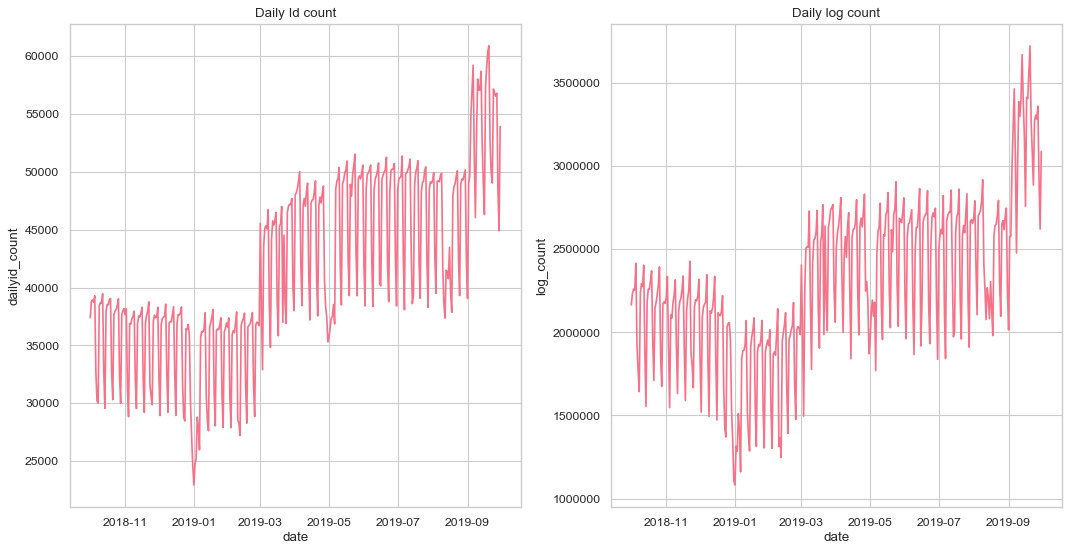

In [13]:
df_summary.date = [datetime.strptime(_d, '%Y/%m/%d') for _d in df_summary.date]
plt.figure(figsize=(16,8), dpi=80)
plt.subplot(121)
sns.lineplot(x='date', y='dailyid_count', 
             data=df_summary,
             estimator=None
            )
plt.title('Daily Id count')
plt.subplot(122)
sns.lineplot(x='date', y='log_count', 
             data=df_summary,
             estimator=None
            )
plt.title('Daily log count')
plt.show()

**Comment/Remarks/Questions**
* The range of the data is from 2018/10/01 to 2019/09/30 (365 days).

* There seems to be a sharp drop in data around New Year, the beggining of May, and August. Could this be due to the holidays? 

* What is causing the sharp rise in the amount of users in March and September? 

* From the plot it seems that the data from June to August seems relatively stable. There are no sudden increase or decrease of id counts during this period. Thus we will gather data from `2019/06/01` to `2019/7/7`.

### Filtering
Because there is a vast amount of data, we need to filter it. For our analysis, we decided to focus on [Tokyo](https://en.wikipedia.org/wiki/Tokyo#Geography_and_government) as it is the capital city and there is a lot of movement within it due to work commute. Because Tokyo is a group of cities, we also need to specify which cities we want to analyze. Due to the fact that the wavelet transform is only possible for signals of lenght $2^n$, we decided to pick 32 areas out of a total of 62. The *city master* file contains the city names and the correspoding city IDs. We will use this to extract 32 cities within the Tokyo province/state.

In [16]:
## Using API to obtain city master file
#citymaster_url = "https://api-tokyochallenge.odpt.org/api/v4/files/Agoop/data/prefcode_citycode_master_UTF-8.csv?acl:consumerKey={}"
#df_citycode = pd.read_csv(citymaster_url.format(consumerKey))
#df_citycode.to_csv('../data/city-master.csv')

df_citycode = pd.read_csv('../data/city-master.csv')
df_citycode.head()

,Unnamed: 0,prefcode,prefname,citycode,cityname,address
0,0,1,北海道,1101,中央区,北海道札幌市中央区
1,1,1,北海道,1102,北区,北海道札幌市北区
2,2,1,北海道,1103,東区,北海道札幌市東区
3,3,1,北海道,1104,白石区,北海道札幌市白石区
4,4,1,北海道,1105,豊平区,北海道札幌市豊平区


In [17]:
tokyo_32_dict = dict(df_citycode[df_citycode.prefname=='東京都'].loc[:,['cityname', 'citycode']].values[:32])
tokyo_32_dict

{'千代田区': 13101,
 '中央区': 13102,
 '港区': 13103,
 '新宿区': 13104,
 '文京区': 13105,
 '台東区': 13106,
 '墨田区': 13107,
 '江東区': 13108,
 '品川区': 13109,
 '目黒区': 13110,
 '大田区': 13111,
 '世田谷区': 13112,
 '渋谷区': 13113,
 '中野区': 13114,
 '杉並区': 13115,
 '豊島区': 13116,
 '北区': 13117,
 '荒川区': 13118,
 '板橋区': 13119,
 '練馬区': 13120,
 '足立区': 13121,
 '葛飾区': 13122,
 '江戸川区': 13123,
 '八王子市': 13201,
 '立川市': 13202,
 '武蔵野市': 13203,
 '三鷹市': 13204,
 '青梅市': 13205,
 '府中市': 13206,
 '昭島市': 13207,
 '調布市': 13208,
 '町田市': 13209}

Now that we have narrowed down the cities we want to examine, we can take a look at the structure of the data set for a certain hour on a certain day. In this case, we arbitrarity choose 10 a.m. on July 21st 2019. For a more detailed discussion on the varibles included in each CSV file visit the [Tokyo Public Transportation Open Data Challenge Website](https://ckan-tokyochallenge.odpt.org/dataset/o_fpd_point-agoop).

In [18]:
url = 'https://api-tokyochallenge.odpt.org/api/v4/files/Agoop/data/PDP_20190721_10.csv?acl:consumerKey='
df_test = pd.read_csv(url + consumerKey)
df_test.head()

,dailyid,year,month,day,dayofweek,hour,minute,latitude,longitude,os,...,course,estimated_course_flag,prefcode,citycode,mesh100mid,home_prefcode,home_citycode,workplace_prefcode,workplace_citycode,transportation_type
0,0c2a3898ec90df81bcc44645a951c20cf329ff04f8cae3...,2019,7,21,7,10,0,35.683613,139.690004,iOS,...,248.639,1.0,13,13113.0,5339452502,13.0,13103.0,13.0,13102.0,7.0
1,c99ceb1da5a754544bba6cd939ec9d29d297d99e179b2e...,2019,7,21,7,10,0,35.685394,139.328220,Android,...,142.781,2.0,13,13201.0,5339422622,13.0,13201.0,13.0,13201.0,2.0
2,ab561147f20de98c19a20b82cacc9c78aac6f239b71eb2...,2019,7,21,7,10,0,35.659354,139.693941,iOS,...,44.648,1.0,13,13113.0,5339359515,13.0,13115.0,13.0,13115.0,2.0
3,d57dff0d21b12cdb58a942877afbdcbf67e12c9f0ead81...,2019,7,21,7,10,0,35.717740,139.736655,iOS,...,346.640,1.0,13,13105.0,5339456819,14.0,14205.0,13.0,13123.0,NaN
4,07d9f2d9291d05bf8b7c3dd5028f8a030d28567d1a59bc...,2019,7,21,7,10,0,35.632304,139.601286,iOS,...,106.875,1.0,13,13112.0,5339345881,13.0,13219.0,13.0,13112.0,1.0


In [10]:
df_test.columns

Index(['dailyid', 'year', 'month', 'day', 'dayofweek', 'hour', 'minute',
       'latitude', 'longitude', 'os', 'home_countryname', 'plmn',
       'plmn_countryname', 'setting_currency', 'setting_language',
       'setting_country', 'logtype_category', 'logtype_subcategory',
       'accuracy', 'speed', 'estimated_speed_flag', 'course',
       'estimated_course_flag', 'prefcode', 'citycode', 'mesh100mid',
       'home_prefcode', 'home_citycode', 'workplace_prefcode',
       'workplace_citycode', 'transportation_type'],
      dtype='object')

To compress the data we define the `count_id` function to count the unique `dailyid` grouped by `citycode` for each hour of each day.

In [15]:
def count_id(df):
    """
    Counts the unique daily id within each city
    """
    return (df.set_index(['citycode'])
            .loc[tokyo_32_dict.values(),['dailyid', 'home_countryname']]
            .reset_index()
            .groupby(['citycode', 'home_countryname'])
            .nunique(['dailyid'])
            .drop(['citycode'], axis=1)
            .reset_index()
           )

We also want to add the date and time in our dataset in order to plot the time series. However this information is contained when we download the dataset from the database. Ideally, we want to automatically generate the datetime strings for a certain range. 

We want to take strings to set our beginning and set how many days worth or data we want to obtain. We can use `data_range` method in python to obtain a range of dates(we can also set the frequency) and then use the `strftime` function in `datetime` library to convert them into the string we want. 

In [ ]:
def append_timestamp(df, date):
    df['datetime']  = date
    return df

Finally, we can use the pandas `pipe` the create a process chain. This makes the code much more readble. 

In [ ]:
(df_test
 .pipe(count_id_by_city)
 .pipe(append_timestamp, '2019-07-21')
 .head()
)

In [ ]:
def get_data(start: str, days: int):
    """
    start: starting date in 'yyyy-mm-dd' format
    days: Number of days of data we want to obtain 
    """
    url = 'https://api-tokyochallenge.odpt.org/api/v4/files/Agoop/data/PDP_{}.csv?acl:consumerKey={}'
    consumerKey = 'hnuzMJ1QGE3TcjlYiXohfA6vkGb55OT9xKtTCcd31L4'
    
    periods = days * 24
    df_list = []
    for date in pd.date_range(start=start, periods=periods, freq='H').tolist():
        date_str = datetime.strftime(date, "%Y%m%d_%H")
        try:
            df = (pd.read_csv(url.format(date_str, consumerKey))
                  .pipe(count_id_by_city)
                  .pipe(append_timestamp, date)
                 )
            df_list.append(df)
            
            print('getting data from: {}'.format(date))
            
            time.sleep(1)
        except:
            continue
            
    return pd.concat(df_list)

In [ ]:
df = get_data('2019-06-01', 10)